<a href="https://colab.research.google.com/github/JuicerPW/T-picos_Especiais4/blob/main/Compara%C3%A7%C3%A3o_regr_e_redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Imports principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

In [7]:
# 1. Gerar dados com variabilidade nas features
np.random.seed(42)
n = 1000

temperatura = np.random.uniform(50, 100, n)
carga = np.random.uniform(5, 35, n)

# Variável target com ruído fixo
vida_util = 6000 - (temperatura * 25) - (carga * 40) + np.random.normal(0, 250, n)

df = pd.DataFrame({
    'Temperatura (°C)': temperatura,
    'Carga (kN)': carga,
    'Vida Útil (h)': vida_util
})


In [44]:
# 2. Dividir os dados

# Seleciona as variáveis independentes (features): Temperatura e Carga
X = df[['Temperatura (°C)', 'Carga (kN)']]

# Seleciona a variável dependente (target): Vida útil
y = df['Vida Útil (h)']

# Divide os dados em treino (80%) e teste (20%), garantindo reprodutibilidade com random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# 3. Regressão Linear

# Cria o modelo de regressão linear
modelo_linear = LinearRegression()

# Treina o modelo com os dados de treino
modelo_linear.fit(X_train, y_train)

# Faz previsões com os dados de teste
y_pred_linear = modelo_linear.predict(X_test)

In [46]:
# 4. Normalização para a rede neural

# Cria normalizadores para X (features) e y (target)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Aplica o fit nos dados de treino de X e transforma (padroniza)
X_train_scaled = scaler_X.fit_transform(X_train)

# Aplica a mesma transformação aos dados de teste de X
X_test_scaled = scaler_X.transform(X_test)

# Para y (target), é necessário usar reshape para ajustar o formato (coluna única)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


In [47]:
# 5. Rede Neural

# Função que define e compila o modelo de rede neural
def construir_modelo():
    modelo = Sequential()
    modelo.add(Dense(10, activation='relu', input_shape=(2,)))  # Camada de entrada com 2 neurônios (2 features)
    modelo.add(Dense(10, activation='relu'))                    # Camada oculta com 10 neurônios
    modelo.add(Dense(1, activation='linear'))                   # Camada de saída com ativação linear
    modelo.compile(optimizer=Adam(learning_rate=0.01), loss='mse')  # Otimizador e função de perda
    return modelo

# Cria o modelo
modelo_nn = construir_modelo()

# Treina a rede neural com os dados normalizados
# Utiliza 20% dos dados de treino como validação interna (val_split)
history = modelo_nn.fit(X_train_scaled, y_train_scaled,
                        epochs=100, batch_size=32, verbose=0, validation_split=0.2)

# Previsões da rede neural com os dados de teste normalizados
y_pred_nn_scaled = modelo_nn.predict(X_test_scaled)

# Inverte a normalização para obter valores reais
y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [48]:
# 6. Avaliação de métricas

# Função que calcula e exibe as principais métricas de regressão
def avaliar_modelo(nome, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)           # Erro absoluto médio
    mse = mean_squared_error(y_true, y_pred)            # Erro quadrático médio
    rmse = np.sqrt(mse)                                 # Raiz do erro quadrático médio
    r2 = r2_score(y_true, y_pred)                       # Coeficiente de determinação (R²)

    print(f"\n📊 Avaliação - {nome}")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Avaliação do modelo de regressão linear
metrics_linear = avaliar_modelo("Regressão Linear", y_test, y_pred_linear)

# Avaliação da rede neural
metrics_nn = avaliar_modelo("Rede Neural", y_test, y_pred_nn)



📊 Avaliação - Regressão Linear
MAE: 198.35
MSE: 62720.14
RMSE: 250.44
R²: 0.8092

📊 Avaliação - Rede Neural
MAE: 201.46
MSE: 63589.08
RMSE: 252.17
R²: 0.8066


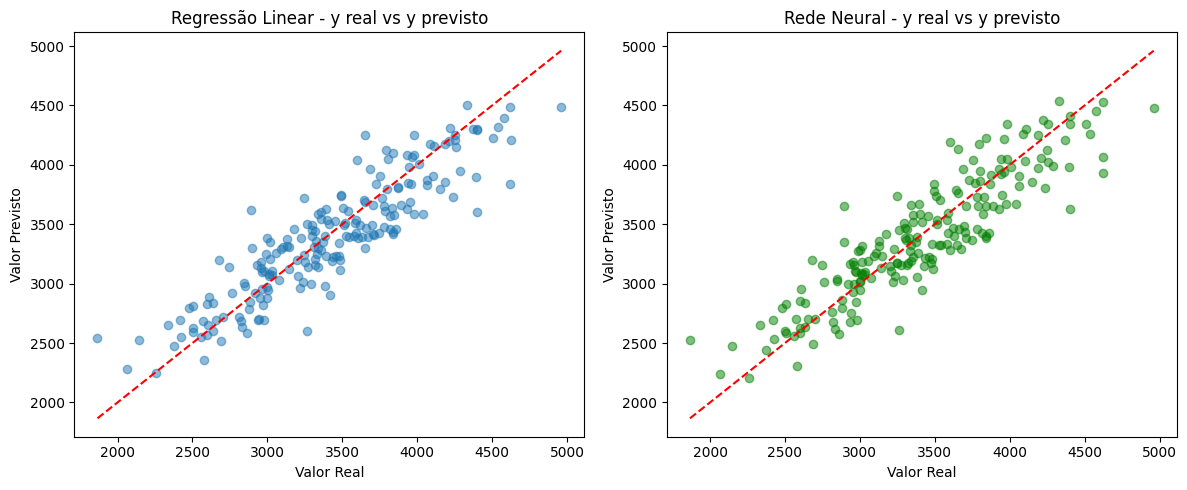

In [49]:
# 7. Gráfico de comparação das previsões

# Cria uma figura com dois subgráficos lado a lado
plt.figure(figsize=(12, 5))

# Subgráfico 1: regressão linear
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Linha ideal (perfeita previsão)
plt.title("Regressão Linear - y real vs y previsto")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")

# Subgráfico 2: rede neural
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_nn, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Rede Neural - y real vs y previsto")
plt.xlabel("Valor Real")
plt.ylabel("Valor Previsto")

# Ajusta o layout para melhor visualização
plt.tight_layout()
plt.show()

                         MAE           MSE        RMSE        R2
Regressão Linear  198.348814  62720.141994  250.439897  0.809233
Rede Neural       201.458756  63589.079142  252.168751  0.806591


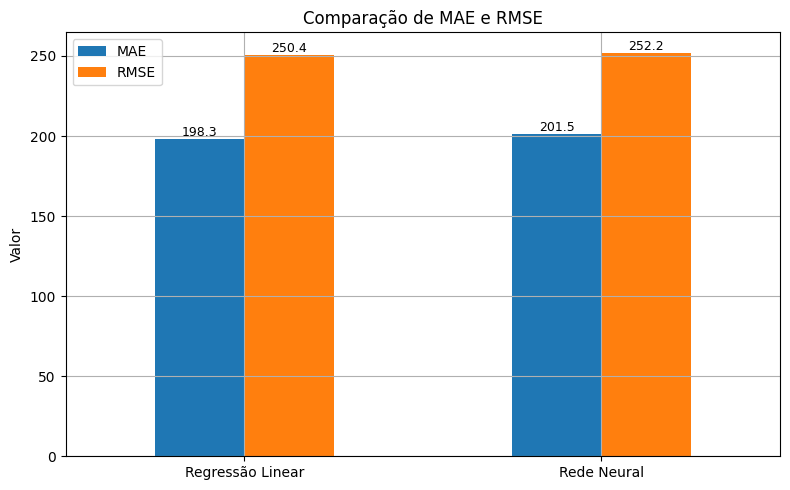

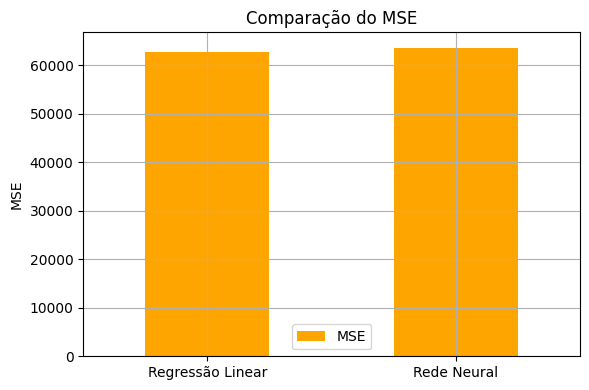

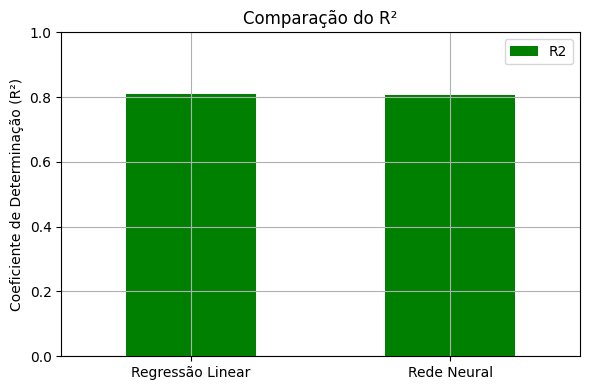

In [62]:
# Crie um DataFrame com as métricas comparando os modelos
df_comparacao = pd.DataFrame({
    'Regressão Linear': metrics_linear,
    'Rede Neural': metrics_nn
})


df_comparacao_T = df_comparacao.T  # Agora as métricas são colunas
df_comparacao_T.columns = ['MAE', 'MSE', 'RMSE', 'R2']
print(df_comparacao_T.head())

# Gráfico de barras lado a lado para MAE e RMSE
ax = df_comparacao_T[['MAE', 'RMSE']].plot(
    kind='bar',
    figsize=(8, 5),
    color=['#1f77b4', '#ff7f0e']  # Cores distintas para MAE e RMSE
)

plt.title("Comparação de MAE e RMSE")
plt.ylabel("Valor")
plt.xticks(rotation=0)
plt.grid(True)

# Adiciona rótulos numéricos nas barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


# Gráfico 2: MSE isolado
df_comparacao_T[['MSE']].plot(kind='bar', figsize=(6,4), color='orange')
plt.title("Comparação do MSE")
plt.ylabel("MSE")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

# Gráfico 3: R² isolado
df_comparacao_T[['R2']].plot(kind='bar', figsize=(6,4), color='green')
plt.title("Comparação do R²")
plt.ylabel("Coeficiente de Determinação (R²)")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

A regressão linear é um modelo estatístico simples, que assume uma relação linear entre as variáveis independentes e o alvo. Por esse motivo, ela tende a apresentar bom desempenho quando os dados seguem uma estrutura linear ou aproximadamente linear, sendo também menos propensa a sobreajuste (overfitting), mesmo com volumes moderados de dados.

Por outro lado, a rede neural é um modelo mais complexo, capaz de capturar padrões não lineares e interações mais sutis entre as variáveis. Sua capacidade de adaptação é maior, o que a torna vantajosa em situações em que os dados apresentam relações não triviais ou comportamentos mais dinâmicos. No entanto, esse poder vem acompanhado de maior sensibilidade a fatores como a escala dos dados, a quantidade de épocas de treinamento, a escolha do otimizador e o risco de sobreajuste caso a rede seja muito complexa em relação ao tamanho do conjunto de dados.
